与往常一样，此示例中的代码将使用`tf.kerasAPI`;如需了解详情，请参阅TensorFlow Keras指南。

在之前的两个示例（分类影评和预测房价）中，我们了解到在训练周期达到一定次数后，模型在验证数据上的准确率会达到峰值，然后便开始下降。

也就是说，模型会过拟合训练数据。请务必学习如何处理过拟合。尽管通常可以在训练集上实现很高的准确率，但我们真正想要的是开发出能够很好地泛化到测试数据（或之前未见过的数据）的模型。

与过拟合相对的是欠拟合。当测试数据仍存在改进空间时，便会发生欠拟合出现这种情况的原因有很多：。模型不够强大，过于正则化，或者根本没有训练足够长的时间这意味着网络未学习训练数据中的相关模式。

如果训练时间过长，模型将开始过拟合，并从训练数据中学习无法泛化到测试数据的模式。我们需要在这两者之间实现平衡。了解如何训练适当的周期次数是一项很实用的技能，接下来我们将介绍这一技能。

为了防止发生过拟合，最好的解决方案是使用更多训练数据。用更多数据进行训练的模型自然能够更好地泛化。如无法采用这种解决方案，则次优解决方案是使用正则化等技术。这些技术会限制模型可以存储的信息的数量和类型。如果网络只能记住少量模式，那么优化过程将迫使它专注于最突出的模式，因为这些模式更有机会更好地泛化。

在此笔记本中，我们将探索两种常见的正则化技术（权重正则化和丢弃），并使用它们改进我们的IMDB影评分类笔记本。

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


### 下载IMDB数据集
我们不会像在上一个笔记本中那样使用嵌入，而是对句子进行多热编码。该模型将很快过拟合训练集。它将用来演示何时发生过拟合，以及如何防止过拟合。

对列表进行多热编码意味着将它们转换为由0和1组成的向量。例如，将序列[3, 5]转换为一个10000维的向量（除索引3和5转换为1之外，其余全为0）。

In [2]:
NUM_WORDS = 10000
(train_data,train_labels),(test_data,test_labels) = keras.datasets.imdb.load_data(num_words=NUM_WORDS)

def multi_hot_sequences(sequences,dimension):
    #Create an all-zero matrix of shape (len(sequences),dimension)
    results = np.zeros((len(sequences),dimension))
    for i,word_indices in enumerate(sequences):
        results[i,word_indices] = 1.0 # set specific indices of results[i] to 1s
    return results

train_data = multi_hot_sequences(train_data,dimension=NUM_WORDS)
test_data = multi_hot_sequences(test_data,dimension=NUM_WORDS)

17465344/17464789 [==============================] - 10s 1us/step


索引按频率排序

In [3]:
train_data[0]

array([0., 1., 1., ..., 0., 0., 0.])

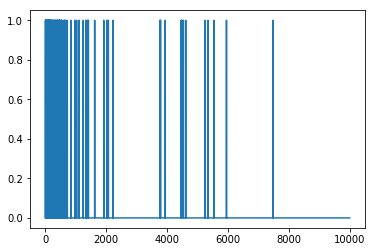

In [4]:
plt.plot(train_data[0])

#### 演示过拟合
要防止过拟合，最简单的方法是缩小模型，即减少模型中可学习参数的数量（由层数和每层的单元数决定）。在深度学习中，模型中可学习参数的数量通常称为模型的“容量”。直观而言，参数越多的模型“记忆容量”越大，因此能够轻松学习训练样本与其目标之间的字典式完美映射（无任何泛化能力的映射），但如果要对之前未见过的数据做出预测，这种映射毫无用处。

请务必谨记：深度学习模型往往善于与训练数据拟合，但真正的挑战是泛化，而非拟合。

另一方面，如果网络的记忆资源有限，便无法轻松学习映射。为了最小化损失，它必须学习具有更强预测能力的压缩表示法。同时，如果模型太小，它将难以与训练数据拟合。我们需要在“太多容量”和“容量不足”这两者之间实现平衡。

遗憾的是，并没有什么神奇公式可用来确定合适的模型大小或架构（由层数或每层的合适大小决定）。您将需要尝试一系列不同的架构。

要找到合适的模型大小，最好先使用相对较少的层和参数，然后开始增加层的大小或添加新的层，直到看到返回的验证损失不断减小为止。我们在影评分类网络上试试这个方法。

将我们仅使用Dense层创建³³一个简单的基准模型，然后创建更小和更大的版本，并比较这些版本。

#### 创建基准模型

In [5]:
baseline_model = keras.Sequential([
    # 'input_shape' is only required here so that '.summary' works
    keras.layers.Dense(16,activation=tf.nn.relu,input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16,activation=tf.nn.relu),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
])

baseline_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy','binary_crossentropy'])
baseline_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160016    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [6]:
baseline_history = baseline_model.fit(train_data,train_labels,epochs=20,
                                     batch_size=512,
                                     validation_data=(test_data,test_labels),
                                     verbose=2)

Train on 25000 samples, validate on 25000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 13s - loss: 0.4855 - acc: 0.8029 - binary_crossentropy: 0.4855 - val_loss: 0.3328 - val_acc: 0.8763 - val_binary_crossentropy: 0.3328
Epoch 2/20
 - 9s - loss: 0.2467 - acc: 0.9116 - binary_crossentropy: 0.2467 - val_loss: 0.2851 - val_acc: 0.8888 - val_binary_crossentropy: 0.2851
Epoch 3/20
 - 5s - loss: 0.1814 - acc: 0.9367 - binary_crossentropy: 0.1814 - val_loss: 0.2911 - val_acc: 0.8843 - val_binary_crossentropy: 0.2911
Epoch 4/20
 - 5s - loss: 0.1482 - acc: 0.9496 - binary_crossentropy: 0.1482 - val_loss: 0.3180 - val_acc: 0.8765 - val_binary_crossentropy: 0.3180
Epoch 5/20
 - 5s - loss: 0.1230 - acc: 0.9596 - binary_crossentropy: 0.1230 - val_loss: 0.3342 - val_acc: 0.8748 - val_binary_crossentropy: 0.3342
Epoch 6/20
 - 5s - loss: 0.1033 - acc: 0.9680 - binary_crossentropy: 0.1033 - val_loss: 0.3625 - val_acc: 0.8706 - val_binary_crossentropy: 0.3625
Epoch 7/20
 - 5s - 

#### 创建一个更小的模型
我们创建一个隐藏单元更少的模型，然后与我们刚刚创建的基准模型进行比较：

In [8]:
smaller_model = keras.Sequential([
    keras.layers.Dense(4,activation=tf.nn.relu,input_shape=(NUM_WORDS,)),
    keras.layers.Dense(4,activation=tf.nn.relu),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
])

smaller_model.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy','binary_crossentropy'])
smaller_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 40004     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 40,029
Trainable params: 40,029
Non-trainable params: 0
_________________________________________________________________


In [9]:
smaller_history = smaller_model.fit(train_data,
                                   train_labels,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(test_data,test_labels),
                                   verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 11s - loss: 0.5603 - acc: 0.7803 - binary_crossentropy: 0.5603 - val_loss: 0.4498 - val_acc: 0.8519 - val_binary_crossentropy: 0.4498
Epoch 2/20
 - 8s - loss: 0.3520 - acc: 0.8946 - binary_crossentropy: 0.3520 - val_loss: 0.3382 - val_acc: 0.8795 - val_binary_crossentropy: 0.3382
Epoch 3/20
 - 5s - loss: 0.2607 - acc: 0.9189 - binary_crossentropy: 0.2607 - val_loss: 0.3027 - val_acc: 0.8839 - val_binary_crossentropy: 0.3027
Epoch 4/20
 - 5s - loss: 0.2154 - acc: 0.9309 - binary_crossentropy: 0.2154 - val_loss: 0.2891 - val_acc: 0.8863 - val_binary_crossentropy: 0.2891
Epoch 5/20
 - 5s - loss: 0.1865 - acc: 0.9406 - binary_crossentropy: 0.1865 - val_loss: 0.2855 - val_acc: 0.8866 - val_binary_crossentropy: 0.2855
Epoch 6/20
 - 5s - loss: 0.1660 - acc: 0.9475 - binary_crossentropy: 0.1660 - val_loss: 0.2871 - val_acc: 0.8854 - val_binary_crossentropy: 0.2871
Epoch 7/20
 - 5s - loss: 0.1487 - acc: 0.9545 - binary_crossentropy

#### 创建一个更大的模型
作为练习，您可以创建一个更大的模型，看看它多快开始过拟合接下来，我们向这个基准添加一个容量大得多的网络，远远超出解决问题所需的容量：

In [10]:
bigger_model = keras.models.Sequential([
    keras.layers.Dense(512,activation=tf.nn.relu,input_shape=(NUM_WORDS,)),
    keras.layers.Dense(512,activation=tf.nn.relu),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
])

bigger_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy','binary_crossentropy'])
bigger_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 512)               5120512   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 513       
Total params: 5,383,681
Trainable params: 5,383,681
Non-trainable params: 0
_________________________________________________________________


再次使用相同的数据训练该模型：

In [11]:
bigger_history = bigger_model.fit(train_data,train_labels,
                                 epochs=20,
                                 batch_size=512,
                                 validation_data=(test_data,test_labels),
                                 verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 18s - loss: 0.3480 - acc: 0.8500 - binary_crossentropy: 0.3480 - val_loss: 0.2931 - val_acc: 0.8811 - val_binary_crossentropy: 0.2931
Epoch 2/20
 - 15s - loss: 0.1450 - acc: 0.9478 - binary_crossentropy: 0.1451 - val_loss: 0.3355 - val_acc: 0.8717 - val_binary_crossentropy: 0.3355
Epoch 3/20
 - 13s - loss: 0.0463 - acc: 0.9867 - binary_crossentropy: 0.0463 - val_loss: 0.4561 - val_acc: 0.8689 - val_binary_crossentropy: 0.4561
Epoch 4/20
 - 11s - loss: 0.0068 - acc: 0.9988 - binary_crossentropy: 0.0068 - val_loss: 0.5920 - val_acc: 0.8684 - val_binary_crossentropy: 0.5920
Epoch 5/20
 - 12s - loss: 8.9095e-04 - acc: 1.0000 - binary_crossentropy: 8.9095e-04 - val_loss: 0.6797 - val_acc: 0.8713 - val_binary_crossentropy: 0.6797
Epoch 6/20
 - 12s - loss: 2.1702e-04 - acc: 1.0000 - binary_crossentropy: 2.1702e-04 - val_loss: 0.7220 - val_acc: 0.8716 - val_binary_crossentropy: 0.7220
Epoch 7/20
 - 11s - loss: 1.3195e-04 - acc: 1.

##### 绘制训练损失和验证损失图表
实线表示训练损失，虚线表示验证损失（请谨记：验证损失越低，表示模型越好）。在此示例中，较小的网络开始过拟合的时间比基准模型晚（前者在6个周期之后，后者在4个周期之后），并且开始过拟合后，它的效果下降速度也慢得多。

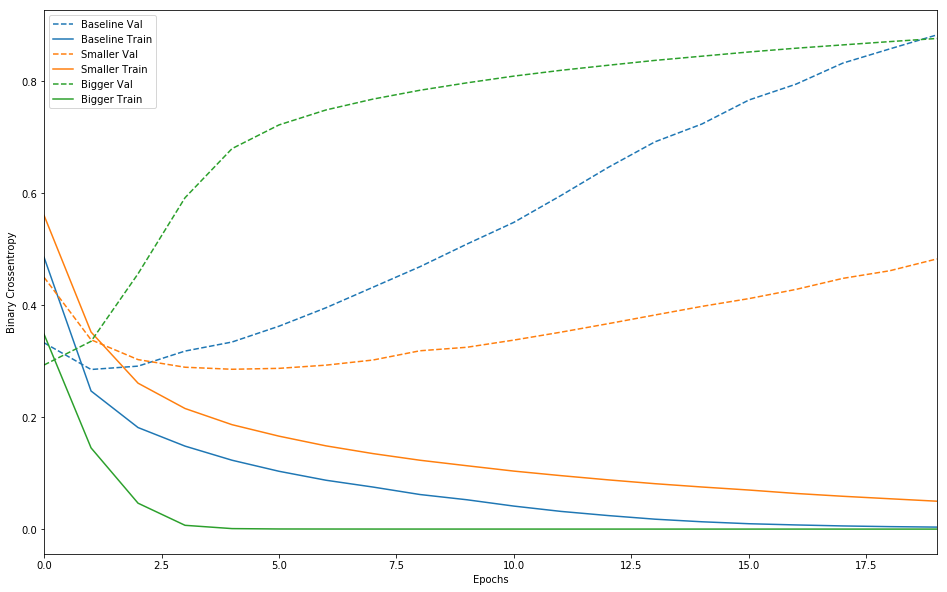

In [13]:
def plot_history(histories,key='binary_crossentropy'):
    plt.figure(figsize=(16,10))
    
    for name, history in histories:
        val = plt.plot(history.epoch,history.history['val_'+key],
                      '--',label=name.title() + ' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')
        
    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_',' ').title())
    plt.legend()
    
    plt.xlim([0,max(history.epoch)])
    
plot_history([
    ('baseline',baseline_history),
    ('smaller',smaller_history),
    ('bigger',bigger_history)
])

请注意，较大的网络几乎仅仅1个周期之后便立即开始过拟合，并且之后严重得多。网络容量越大，便能够越快对训练数据进行建模（产生较低的训练损失），但越容易过拟合（导致训练损失与验证损失之间的差异很大）。
##### 策略
###### 添加权重正则化
您可能熟悉奥卡姆剃刀定律：如果对于同一现象有两种解释，最可能正确的解释是“最简单”的解释，即做出最少量假设的解释这也适用于神经网络学习的模型：给定一些训练数据和一个网络架构，有多组权重值（多个模型）可以解释数据，而简单模型比复杂模型更不容易过拟合。

在这种情况下，“简单模型”是一种参数值分布的熵较低的模型（或者具有较少参数的模型，如我们在上面的部分中所见）。因此，要缓解过拟合，一种常见方法是限制网络的复杂性，具体方法是强制要求其权重仅采用较小的值，使权重值的分布更“规则”。这称为“权重正则化”，通过向网络的损失函数。添加与权重较大相关的代价来实现这个代价分为两种类型：

- L1正则化，其中所添加的代价与权重系数的绝对值（即所谓的权重“L1范数”）成正比。

- L2正则化，其中所添加的代价与权重系数值的平方（即所谓的权重“L2范数”）成正比.L2正则化在神经网络领域也称为权重衰减。不要因为名称不同而感到困惑：从数学角度来讲，权重衰减与L2正则化完全相同。

在`tf.keras`中，权重正则化的添加方法如下：将权重正则化项实例作为关键字参数传递给层。现在，我们来添加L2权重正则化。

In [16]:
l2_model = keras.models.Sequential([
    keras.layers.Dense(16,kernel_regularizer=keras.regularizers.l2(0.001),
                      activation=tf.nn.relu,input_shape=(NUM_WORDS,)),
    keras.layers.Dense(16,kernel_regularizer=keras.regularizers.l2(0.001),
                      activation=tf.nn.relu),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
])

l2_model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy','binary_crossentropy'])

l2_model_history = l2_model.fit(train_data,train_labels,
                                epochs=20,
                                batch_size=512,
                                validation_data=(test_data,test_labels),
                                verbose=2)

Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 13s - loss: 0.5487 - acc: 0.7971 - binary_crossentropy: 0.5110 - val_loss: 0.3993 - val_acc: 0.8707 - val_binary_crossentropy: 0.3594
Epoch 2/20
 - 7s - loss: 0.3198 - acc: 0.9033 - binary_crossentropy: 0.2748 - val_loss: 0.3376 - val_acc: 0.8873 - val_binary_crossentropy: 0.2886
Epoch 3/20
 - 5s - loss: 0.2627 - acc: 0.9257 - binary_crossentropy: 0.2108 - val_loss: 0.3368 - val_acc: 0.8866 - val_binary_crossentropy: 0.2829
Epoch 4/20
 - 5s - loss: 0.2382 - acc: 0.9364 - binary_crossentropy: 0.1823 - val_loss: 0.3477 - val_acc: 0.8821 - val_binary_crossentropy: 0.2906
Epoch 5/20
 - 5s - loss: 0.2215 - acc: 0.9444 - binary_crossentropy: 0.1632 - val_loss: 0.3599 - val_acc: 0.8799 - val_binary_crossentropy: 0.3005
Epoch 6/20
 - 5s - loss: 0.2088 - acc: 0.9505 - binary_crossentropy: 0.1482 - val_loss: 0.3711 - val_acc: 0.8769 - val_binary_crossentropy: 0.3098
Epoch 7/20
 - 5s - loss: 0.1995 - acc: 0.9540 - binary_crossentropy

`l2(0.001)`层表示权的重矩阵中的每个系数都会将`0.001 * weight_coefficient_value**2`添加到网络的总损失中。请注意，由于此惩罚仅在训练时添加，此网络在训练时的损失将远高于测试时。

以下是L2正则化惩罚的影响：

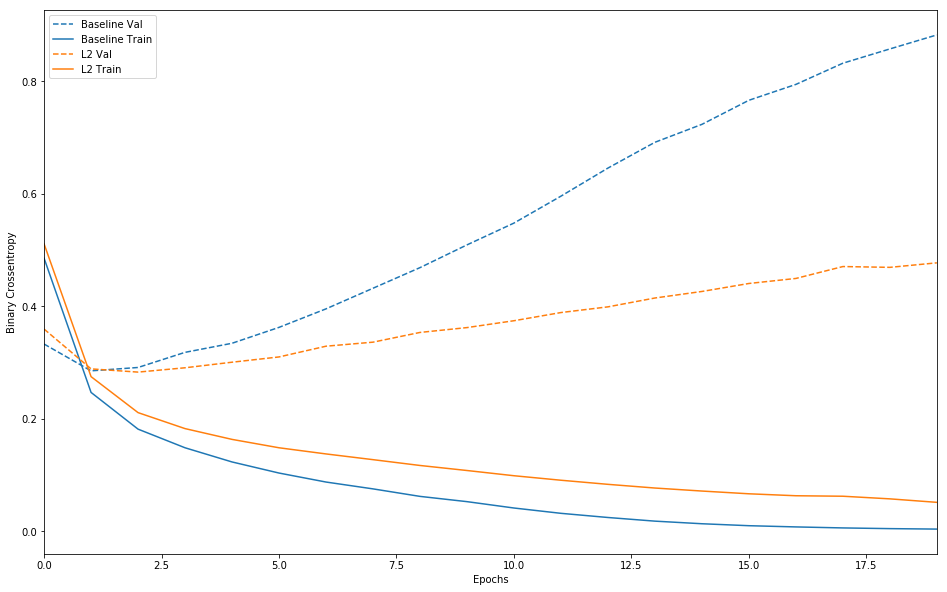

In [17]:
plot_history([
    ('baseline',baseline_history),
    ('l2',l2_model_history)
])

#### 添加丢弃层
丢弃是由Hinton及其在多伦多大学的学生开发的，是最有效且最常用的神经网络正则化技术之一。丢弃（应用于某个层）是指在训练期间随机“丢弃”（即设置为0）该层的多个输出特征。假设某个指定的层通常会在训练期间针对给定的输入样本返回一个向量[0.2,0.5,1.3,0.8,1.1];在应用丢弃后，此向量将随机分布几个0条目，例如[0,0.5,1.3,0,1.1]。“丢弃率”指变为0的特征所占的比例，通常设置在0.2和0.5之间。在测试时，网络不会丢弃任何单元，而是将层的输出值按等同于丢弃率的比例进行缩减，以便平衡以下事实：测试时的活跃单元数大于训练时的活跃单元数。

在tf.keras中，您可以通过丢弃层将丢弃引入网络中，以便事先将其应用于层的输出。

下面我们在IMDB网络中添加两个丢弃层，看看它们在降低过拟合方面表现如何：

In [18]:
dpt_model = keras.models.Sequential([
    keras.layers.Dense(16,activation=tf.nn.relu,input_shape=(NUM_WORDS,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16,activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1,activation=tf.nn.sigmoid)
])

dpt_model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy','binary_crossentropy'])

dpt_model_history = dpt_model.fit(train_data,train_labels,
                                 epochs=20,
                                 batch_size=512,
                                 validation_data=(test_data,test_labels),
                                 verbose=2)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
 - 12s - loss: 0.6300 - acc: 0.6310 - binary_crossentropy: 0.6300 - val_loss: 0.5074 - val_acc: 0.8488 - val_binary_crossentropy: 0.5074
Epoch 2/20
 - 7s - loss: 0.4669 - acc: 0.7968 - binary_crossentropy: 0.4669 - val_loss: 0.3525 - val_acc: 0.8813 - val_binary_crossentropy: 0.3525
Epoch 3/20
 - 5s - loss: 0.3643 - acc: 0.8661 - binary_crossentropy: 0.3643 - val_loss: 0.2954 - val_acc: 0.8881 - val_binary_crossentropy: 0.2954
Epoch 4/20
 - 5s - loss: 0.2974 - acc: 0.9013 - binary_crossentropy: 0.2974 - val_loss: 0.2796 - val_acc: 0.8889 - val_binary_crossentropy: 0.2796
Epoch 5/20
 - 5s - loss: 0.2547 - acc: 0.9176 - binary_crossentropy: 0.2547 - val_loss: 0.2764 - val_acc: 0.8889 - val_binary_crossentropy: 0.2764
Epoch 6/20
 - 5s - loss: 0.2234 - acc: 0.9307 - binary_crossentropy: 0.2234 - val_loss: 0.2904 - va

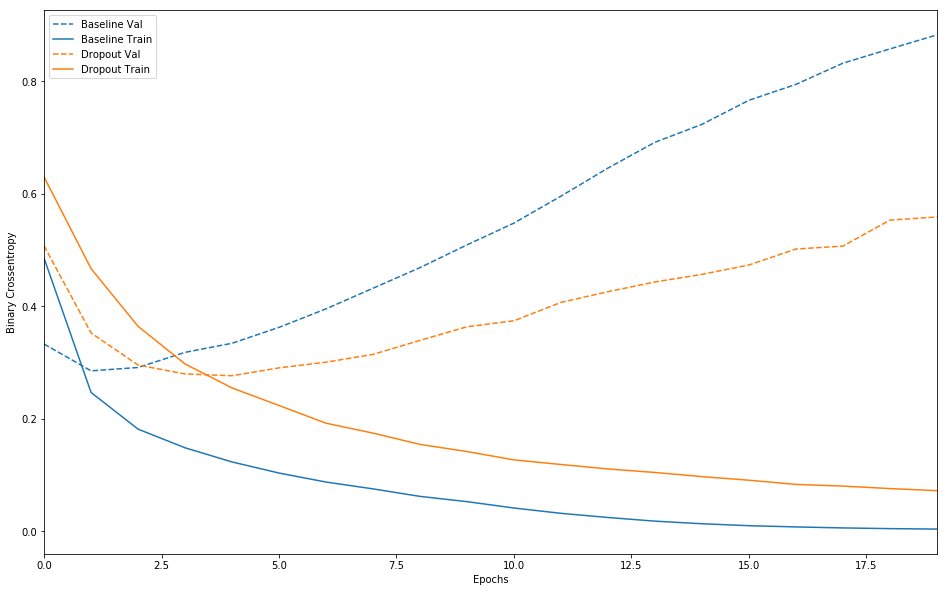

In [22]:
plot_history([
    ('baseline',baseline_history),
    ('dropout',dpt_model_history)
])

添加丢弃层可明显改善基准模型。

下面总结一下防止神经网络出现过拟合的最常见方法：

- 获取更多训练数据。
- 降低网络容量。
- 添加权重正则化。
- 添加丢弃层。

还有两个重要的方法在本指南中没有介绍：数据增强和批次归一化。